In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from preprocessing.feature_extractor import FeatureExtractor

In [15]:
data_dir = "../data/Composer_Dataset"
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
scalar_features, multidimensional_features = FeatureExtractor.extract_features_for_directory(data_dir, composers)

Loading existing features from ../data/Composer_Dataset\extracted_features.pkl


In [16]:
scalar_features.head()

,max_independent_voices,avg_independent_voices,var_independent_voices,avg_simultaneity,var_simultaneity,note_density,avg_note_duration,var_note_duration,initial_tempo,time_signature_numerator,...,perfect_vertical_intervals,vertical_minor_seconds,vertical_thirds,vertical_fifths,vertical_tritones,vertical_octaves,avg_chord_duration,length,file_name,composer
0,4.0,3.868889,0.337522,3.829787,0.807390,6.755565,0.592104,0.341892,184.000258,4.0,...,0.401902,0.002774,0.311138,0.168450,0.030123,0.124059,0.441176,46.956456,003706b_.mid,Bach
1,4.0,3.920000,0.271293,4.000000,0.000000,5.622222,0.711462,0.341781,109.714286,4.0,...,0.408951,0.002315,0.339506,0.179784,0.035880,0.137731,0.576923,45.000000,003806b_.mid,Bach
2,4.0,3.943529,0.230828,4.000000,0.000000,6.705882,0.596491,0.254569,140.800000,4.0,...,0.414447,0.002421,0.301049,0.168684,0.033091,0.144471,0.456989,42.500000,003907bv.mid,Bach
3,4.0,3.943529,0.230828,4.000000,0.000000,6.705882,0.596491,0.254569,140.800000,4.0,...,0.414447,0.002421,0.301049,0.168684,0.033091,0.144471,0.456989,42.500000,003907b_.mid,Bach
4,4.0,3.893238,0.308810,3.746667,0.974246,7.253333,0.551471,0.186561,147.692308,4.0,...,0.375940,0.005639,0.332707,0.168546,0.052005,0.115288,0.419403,30.000000,004003b_.mid,Bach


In [17]:
print(f"Piano Roll Shape: {multidimensional_features[0]['piano_roll'].shape}")
print(f"Chroma Piano Roll Shape: {multidimensional_features[0]['chroma_piano_roll'].shape}")
print(f"Pitch Class Histogram Shape: {multidimensional_features[0]['pitch_class_histogram'].shape}")
print(f"Pitch Class Transition Matrix Shape: {multidimensional_features[0]['pitch_class_transition_matrix'].shape}")

Piano Roll Shape: (128, 469)
Chroma Piano Roll Shape: (12, 469)
Pitch Class Histogram Shape: (12,)
Pitch Class Transition Matrix Shape: (12, 12)


In [19]:
scalar_features = scalar_features.drop('file_name', axis=1)
x = scalar_features.drop('composer', axis=1)
y = scalar_features['composer']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [20]:
classifier = HistGradientBoostingClassifier(random_state=1)
classifier.fit(x_train, y_train)

HistGradientBoostingClassifier(random_state=1)

In [21]:
y_pred = classifier.predict(x_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        Bach       0.93      0.98      0.95       209
   Beethoven       0.78      0.74      0.76        43
      Chopin       0.96      0.68      0.79        34
      Mozart       0.74      0.78      0.76        41

    accuracy                           0.89       327
   macro avg       0.85      0.79      0.82       327
weighted avg       0.89      0.89      0.89       327



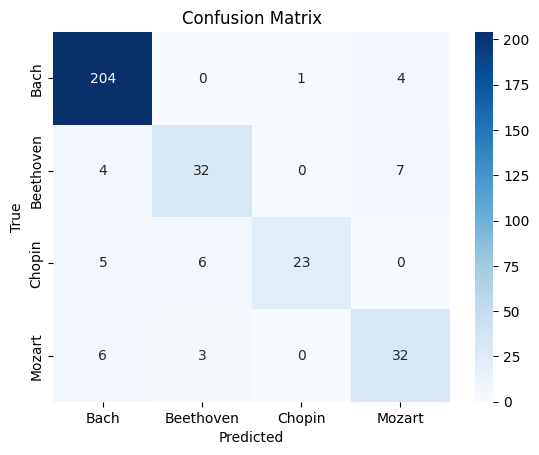

In [22]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()